In [39]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.models
from PIL import Image
import numpy as nps
import matplotlib.pyplot as plt
from lib.autoencoder import FeatureEncoder
from lib.attention_model import AttentionLayer
from lib.correspondence_datamodule import CorrespondenceDataModule
from lib.warping import *
from externals.d2net.lib.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
megadepth_path = "/mnt/c/Users/phill/polybox/Deep Learning/MegaDepthDataset"
data_module = CorrespondenceDataModule(base_path=megadepth_path, batch_size=1)
data_module.prepare_data()
data_module.setup(stage='fit')
dl_train = data_module.train_dataloader()
dl_val = data_module.val_dataloader()



  0%|          | 0/1 [00:00<?, ?it/s]

Building a new training dataset...


  0%|          | 0/1 [00:00<?, ?it/s]

Building the validation dataset...


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


In [4]:
def triplet_margin_loss(x1_encoded, x2_encoded, attentions1, \
    attentions2, correspondences, idx, margin=1, safe_radius=4, scaling_steps=3, plot=False):
    """
    x1_encoded: 1xBx48xWxH (dense_features1) (usually x32x32)
    x2_encoded: 1xBx48xWxH (dense_features2) (usually x32x32)
    attentions1: 1xBx1xWxH (scores1)
    attentions2: 1xBx1xWxH (scores2)
    correspondences (image1: 1xBx3x256x256 = 1xBx3xw1xh1, ...) -> 32 * 8 = 256 --> 3 scaling steps
    idx: batch index (basically loop over all images in the batch)
    out: scalar tensor (1)
    """
    loss = torch.tensor(np.array([0], dtype=np.float32), device=device)
    
    depth1 = correspondences['depth1'][idx] # [h1, w1]???
    intrinsics1 = correspondences['intrinsics1'][idx]  # [3, 3]
    pose1 = correspondences['pose1'][idx].view(4, 4)  # [4, 4]
    bbox1 = correspondences['bbox1'][idx]  # [2]

    depth2 = correspondences['depth2'][idx]
    intrinsics2 = correspondences['intrinsics2'][idx]
    pose2 = correspondences['pose2'][idx].view(4, 4)
    bbox2 = correspondences['bbox2'][idx]
    

    # Network output
    dense_features1 = x1_encoded[idx] #48x32x32
    c, h1, w1 = dense_features1.size()
    scores1 = attentions1[idx].view(-1) #1x1024 (ids format)

    dense_features2 = x2_encoded[idx]
    _, h2, w2 = dense_features2.size()
    scores2 = attentions2[idx].view(-1)

    all_descriptors1 = F.normalize(dense_features1.view(c, -1), dim=0)# 48x1024, row-major
    descriptors1 = all_descriptors1

    all_descriptors2 = F.normalize(dense_features2.view(c, -1), dim=0)# 48x1024

    # Warp the positions from image 1 to image 2
    fmap_pos1 = grid_positions(h1, w1, device) #feature positions, 2x(32*32)=2x1024 [y,x]-format -> [[0,0],[0,1], ...[32,32]]
    pos1 = upscale_positions(fmap_pos1, scaling_steps=scaling_steps) # feature positions in 256x256, [y,x]-format -> [[0,0],[0,11.5], ...[256,256]]
    #ids: matching ids in sequence (256*256)
    #default pos1 has ids [0, ..., 1024]
    # now ids says which of these are valid based on relative transformation between them, e.g.
    # [5, 28, 32, ...,1020]
    # so a legal correspondence would be pos1[:,5]<-->pos2[:,5]
    try:
        pos1, pos2, ids = warp(pos1,
            depth1, intrinsics1, pose1, bbox1,
            depth2, intrinsics2, pose2, bbox2)
    except EmptyTensorError:
        return loss
    fmap_pos1 = fmap_pos1[:, ids] #uv-positions on 32x32 grid, but in list format 2xlen(ids)
    descriptors1 = descriptors1[:, ids] #again as list 48xlen(ids)
    scores1 = scores1[ids] #again as list 1xlen(ids)

    # Skip the pair if not enough GT correspondences are available
    if ids.size(0) < 128:
        return loss

    # Descriptors at the corresponding positions
    fmap_pos2 = torch.round(
        downscale_positions(pos2, scaling_steps=scaling_steps)
    ).long()
    descriptors2 = F.normalize(
        dense_features2[:, fmap_pos2[0, :], fmap_pos2[1, :]],
        dim=0
    )
    positive_distance = 2 - 2 * (
        descriptors1.t().unsqueeze(1) @ descriptors2.t().unsqueeze(2)
    ).squeeze() #p(c) in paper, ||dA -dB||

    all_fmap_pos2 = grid_positions(h2, w2, device)
    position_distance = torch.max(
        torch.abs(
            fmap_pos2.unsqueeze(2).float() -
            all_fmap_pos2.unsqueeze(1)
        ),
        dim=0
    )[0] # all other distances within image2 (distance is feature-metric norm!)
    is_out_of_safe_radius = position_distance > safe_radius
    distance_matrix = 2 - 2 * (descriptors1.t() @ all_descriptors2) # ||dA -dN2||
    negative_distance2 = torch.min(
        distance_matrix + (1 - is_out_of_safe_radius.float()) * 10., #weird
        dim=1
    )[0] 

    all_fmap_pos1 = grid_positions(h1, w1, device)
    position_distance = torch.max(
        torch.abs(
            fmap_pos1.unsqueeze(2).float() -
            all_fmap_pos1.unsqueeze(1)
        ),
        dim=0
    )[0]
    is_out_of_safe_radius = position_distance > safe_radius
    distance_matrix = 2 - 2 * (descriptors2.t() @ all_descriptors1)  # ||dB -dN1||
    negative_distance1 = torch.min(
        distance_matrix + (1 - is_out_of_safe_radius.float()) * 10., #weird
        dim=1
    )[0]

    diff = positive_distance - torch.min(
        negative_distance1, negative_distance2
    ) # (n(c))

    scores2 = scores2[fmap_pos2[0, :], fmap_pos2[1, :]]

    loss = loss + (
        torch.sum(scores1 * scores2 * F.relu(margin + diff)) /
        torch.sum(scores1 * scores2)
    )

In [5]:
batch = next(iter(dl_train))


In [40]:
batch["image1"].shape

torch.Size([1, 3, 256, 256])

torch.Size([1, 48, 32, 32])
torch.Size([1, 48, 32, 32])
torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])
[[  3.5   3.5   3.5 ... 251.5 251.5 251.5]
 [107.5 115.5 123.5 ...  43.5  51.5  59.5]]
[[ 17.599579   18.243591   19.073608  ... 249.31195   249.74799
  250.07     ]
 [  1.0601807   9.577393   16.848083  ...  19.955994   30.400635
   44.229004 ]]
tensor([1.0452], grad_fn=<DivBackward0>)
torch.Size([1])


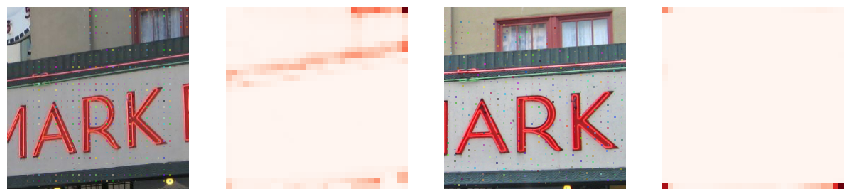

In [77]:
x1 = batch['image1']
x2 = batch["image2"]
feature_encoder = FeatureEncoder()
attention_model = AttentionLayer(feature_encoder)

with torch.no_grad():
    x1_encoded = attention_model.concat_layers(attention_model.feature_encoder.forward(x1)) #bx48x32x32
    x2_encoded = attention_model.concat_layers(attention_model.feature_encoder.forward(x2))


print(x1_encoded.shape)
print(x2_encoded.shape)
# x1_encoded.requires_grad = False
# x2_encoded.requires_grad = False
y1 = attention_model.forward(x1_encoded) #bx1x32x32
y2 = attention_model.forward(x2_encoded)

print(y1.shape)
print(y2.shape)


loss = attention_model.loss(x1_encoded, x2_encoded, y1, y2, batch)
print(loss)
print(loss.shape)